# Rodriguez model explanations

## First we need dataframes for every subject

In [2]:
import sys
sys.path.append('../')

# %matplotlib inline

# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import pandas as pd
import numpy as np
import utils

# DEFINE GRAPH
from importlib import reload
reload(utils)


<module 'utils' from '/home/sofia/Documents/painface-recognition/notebooks/utils.py'>

In [3]:
# Data paths
rgb_path = '../data/jpg_128_128_2fps/'
of_path = 'no'

# Hyperparameters
input_width = 128
input_height = 128
seq_length = 10
seq_stride = 10
batch_size = 1
COLOR = True
nb_labels = 2

# Data augmentation
aug_flip = 0
aug_crop = 0
aug_light = 0

subject_ids = pd.read_csv('../metadata/horse_subjects.csv')['Subject'].values
channels = 3

In [4]:
from utils import ArgsProxy
args = ArgsProxy(rgb_path, of_path, input_height, input_width,
                 seq_length, seq_stride, batch_size, nb_labels,
                 aug_flip, aug_crop, aug_light)

In [5]:
import data_handler as dathand
dh = dathand.DataHandler(path=args.data_path,
                         of_path=args.of_path,
                         clip_list_file='videos_overview_missingremoved.csv',
                         data_columns=['Pain'],  # Here one can append f. ex. 'Observer'
                         image_size=(args.input_height, args.input_width),
                         seq_length=args.seq_length,
                         seq_stride=args.seq_stride,
                         batch_size=args.batch_size,
                         color=COLOR,
                         nb_labels=args.nb_labels,
                         aug_flip=args.aug_flip,
                         aug_crop=args.aug_crop,
                         aug_light=args.aug_light)

In [6]:
import utils
subject_dfs = utils.read_or_create_subject_dfs(dh, args, subject_ids)

../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/


In [7]:
sequence_df = utils.get_sequence(args=args, subject_dfs=subject_dfs, subject=4)
y = sequence_df['Pain'].values
image_paths = sequence_df['Path'].values

In [8]:
from keras.utils import np_utils
label_onehot = np_utils.to_categorical(y, num_classes=args.nb_labels)
batch_label = label_onehot.reshape(args.batch_size, -1)
batch_img = np.concatenate(utils.read_images_and_return_list(args, image_paths), axis=1)

## Now that we have frames from all subjects, we can load the model we want to test.

In [8]:
# Choose a model to work on
best_model_path = '../models/BEST_MODEL_rodriguez_adadelta_LSTMunits_1024_CONVfilters_None_jpg128_2fps_val4_t1_seq10ss10_4hl_1024ubs16_no_aug_run2.h5'
import keras
m = keras.models.load_model(best_model_path)

In [9]:
m.layers

In [16]:
from keras import backend as K
import tensorflow as tf
    
images = tf.placeholder(tf.float32, [batch_size, args.seq_length, args.input_width, args.input_height, channels])
labels = tf.placeholder(tf.float32, [batch_size, args.seq_length, 2])
model = utils.RodriguezNetwork(images, path=best_model_path)

sess = K.get_session()  # Grab the Keras session where the weights are initialized.

cost = (-1) * tf.reduce_sum(tf.multiply(labels, tf.log(model.preds)), axis=1)
    
y_c = tf.reduce_sum(tf.multiply(model.preds, labels), axis=1)

target_conv_layer = model.timedist_vgg # Choose which layer to study
    
target_conv_layer_grad = tf.gradients(y_c, target_conv_layer)[0]
    
gb_grad = tf.gradients(cost, images)[0]  # Guided backpropagation back to input layer



In [27]:
def run_on_one_sequence(sess, model, batch_img):
    with sess.as_default():
        prob = sess.run(model.preds,
                        feed_dict={images: batch_img,
                                   K.learning_phase(): 0})

        print(prob)
        gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value = sess.run([gb_grad, target_conv_layer, target_conv_layer_grad],
                      feed_dict={images: batch_img,
                      labels: batch_label,
                      K.learning_phase(): 0})
        target_conv_layer_value = np.reshape(target_conv_layer_value,
                                     (1, 10, 128, 128, 3))
        target_conv_layer_grad_value = np.reshape(target_conv_layer_grad_value,
                                     (1, 10, 128, 128, 3))


    utils.visualize_overlays(batch_img, target_conv_layer_value,
                       target_conv_layer_grad_value)

    for i in range(seq_length):
        print(prob[0,i,:])
    print(batch_label)

# Rodriguez predictions for subject 1

[[[ 0.47044626  0.55444312]
  [ 0.43396974  0.54555082]
  [ 0.28791618  0.63364023]
  [ 0.27653202  0.75894076]
  [ 0.22352983  0.90104741]
  [ 0.16850147  0.75590754]
  [ 0.21564822  0.80393273]
  [ 0.15170136  0.81833994]
  [ 0.233991    0.81309575]
  [ 0.26685816  0.82860011]]]


/home/sofia/miniconda3/envs/pfr_june/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


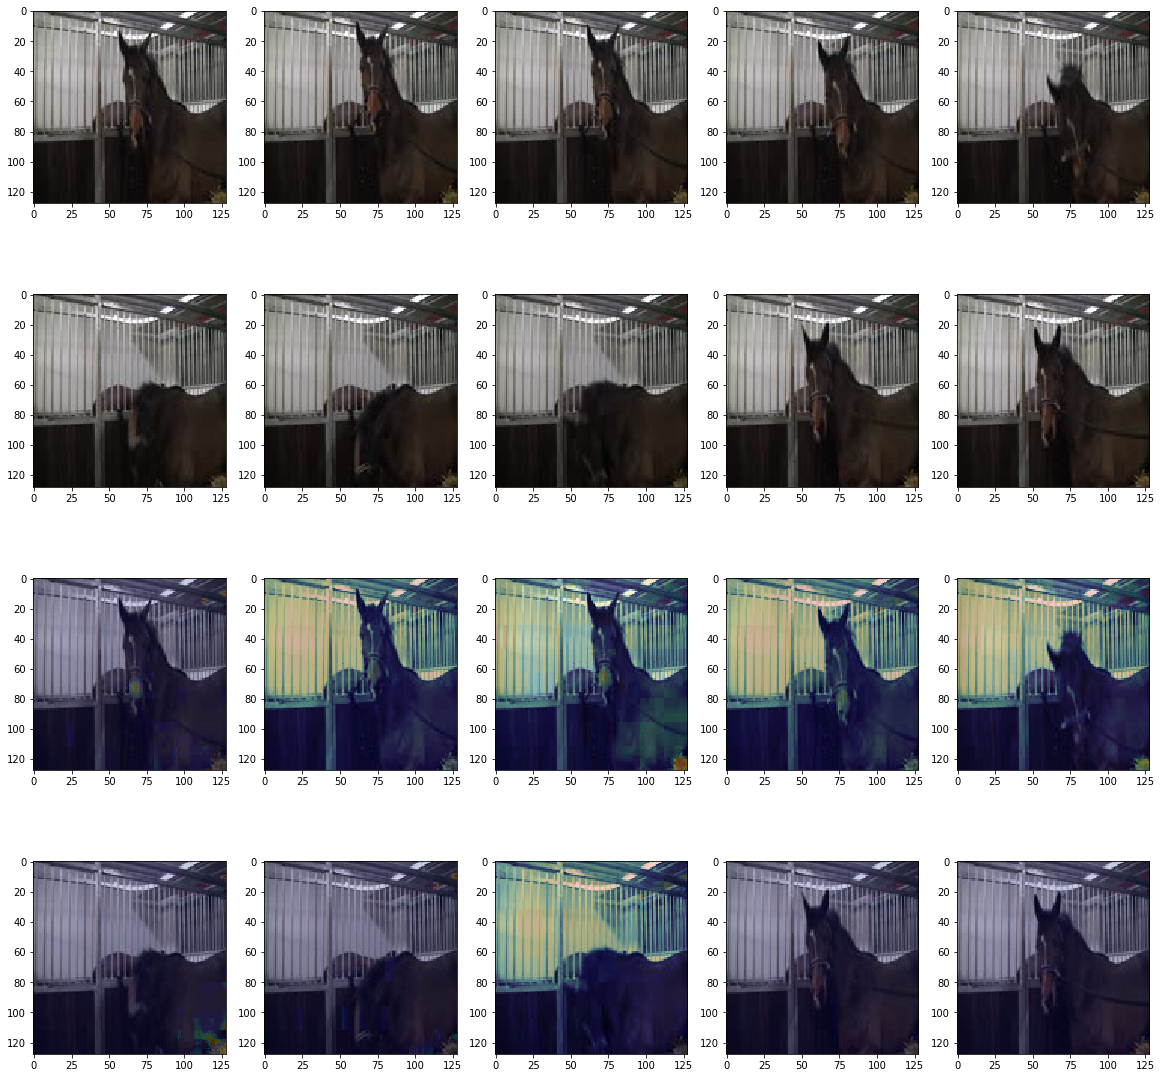

[ 0.47044626  0.55444312]
[ 0.43396974  0.54555082]
[ 0.28791618  0.63364023]
[ 0.27653202  0.75894076]
[ 0.22352983  0.90104741]
[ 0.16850147  0.75590754]
[ 0.21564822  0.80393273]
[ 0.15170136  0.81833994]
[ 0.233991    0.81309575]
[ 0.26685816  0.82860011]
[[[0 1]
  [0 1]
  [0 1]
  [0 1]
  [0 1]
  [0 1]
  [0 1]
  [0 1]
  [0 1]
  [0 1]]]


In [36]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, subject=1)
batch_img = np.array(batch_img, dtype=np.float32)
batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img)

[[[  1.29690079e-03   9.98887956e-01]
  [  2.50482961e-04   9.99640107e-01]
  [  2.36719410e-04   9.99741018e-01]
  [  1.87249563e-04   9.99827325e-01]
  [  2.25962067e-04   9.99807298e-01]
  [  1.05549167e-04   9.99774277e-01]
  [  1.31986599e-04   9.99796689e-01]
  [  1.68884144e-04   9.99685287e-01]
  [  4.71899199e-04   9.99550283e-01]
  [  3.94128438e-04   9.99536514e-01]]]


/home/sofia/miniconda3/envs/pfr_june/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


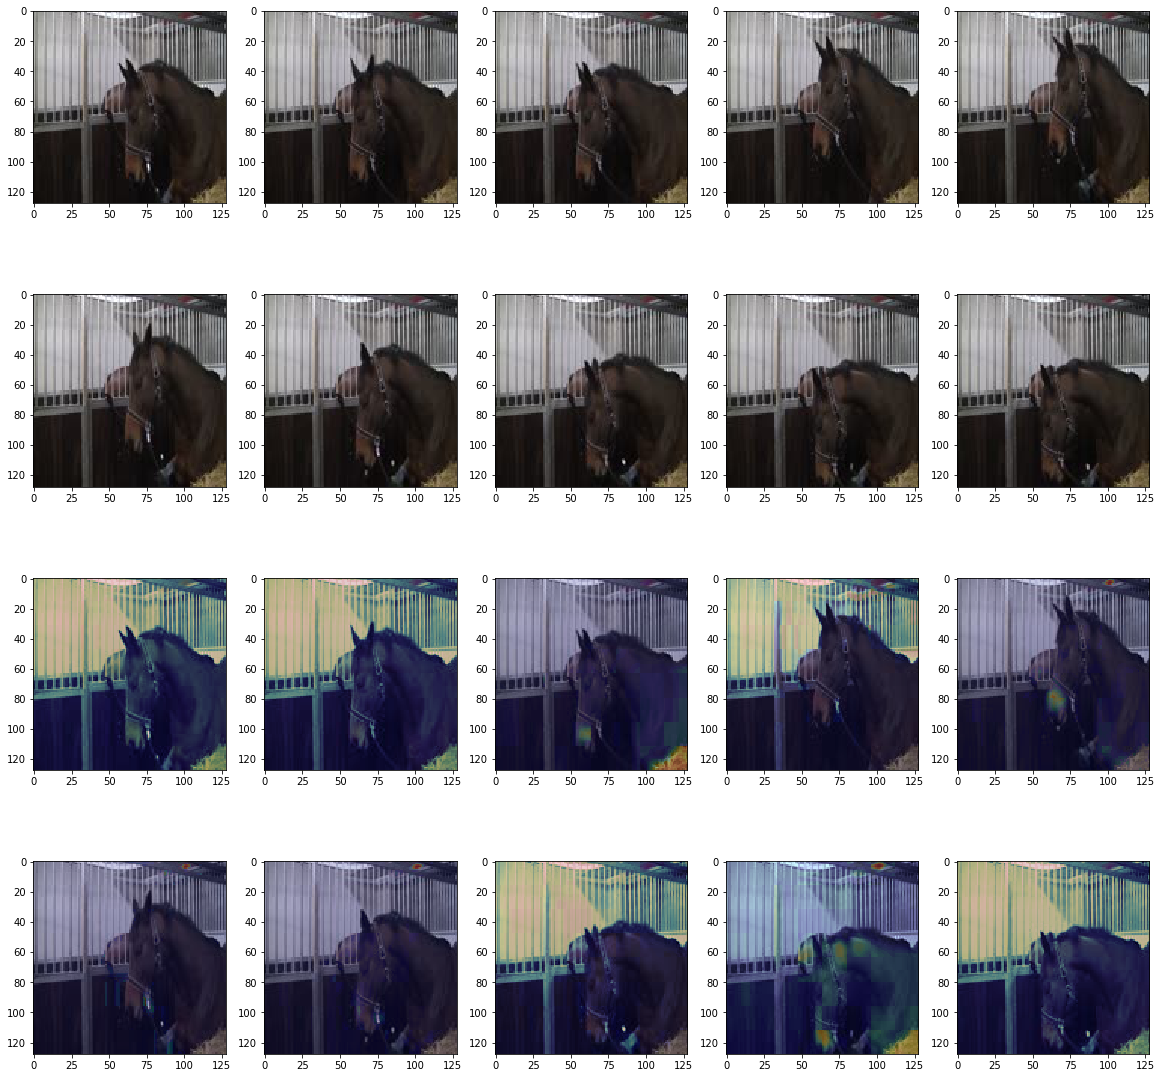

[ 0.0012969   0.99888796]
[  2.50482961e-04   9.99640107e-01]
[  2.36719410e-04   9.99741018e-01]
[  1.87249563e-04   9.99827325e-01]
[  2.25962067e-04   9.99807298e-01]
[  1.05549167e-04   9.99774277e-01]
[  1.31986599e-04   9.99796689e-01]
[  1.68884144e-04   9.99685287e-01]
[  4.71899199e-04   9.99550283e-01]
[  3.94128438e-04   9.99536514e-01]
[[[0 1]
  [0 1]
  [0 1]
  [0 1]
  [0 1]
  [0 1]
  [0 1]
  [0 1]
  [0 1]
  [0 1]]]


In [37]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, subject=1)
batch_img = np.array(batch_img, dtype=np.float32)
batch_label = np.array(batch_label, dtype=np.uint8)

run_on_one_sequence(sess, model, batch_img)

[[[ 0.97774637  0.01279034]
  [ 0.99168915  0.00312271]
  [ 0.99299002  0.00278417]
  [ 0.99449807  0.00294291]
  [ 0.99581796  0.00225513]
  [ 0.99635738  0.00153835]
  [ 0.99775189  0.00202645]
  [ 0.99844921  0.00123806]
  [ 0.99777967  0.00102238]
  [ 0.99871111  0.00139166]]]


/home/sofia/miniconda3/envs/pfr_june/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


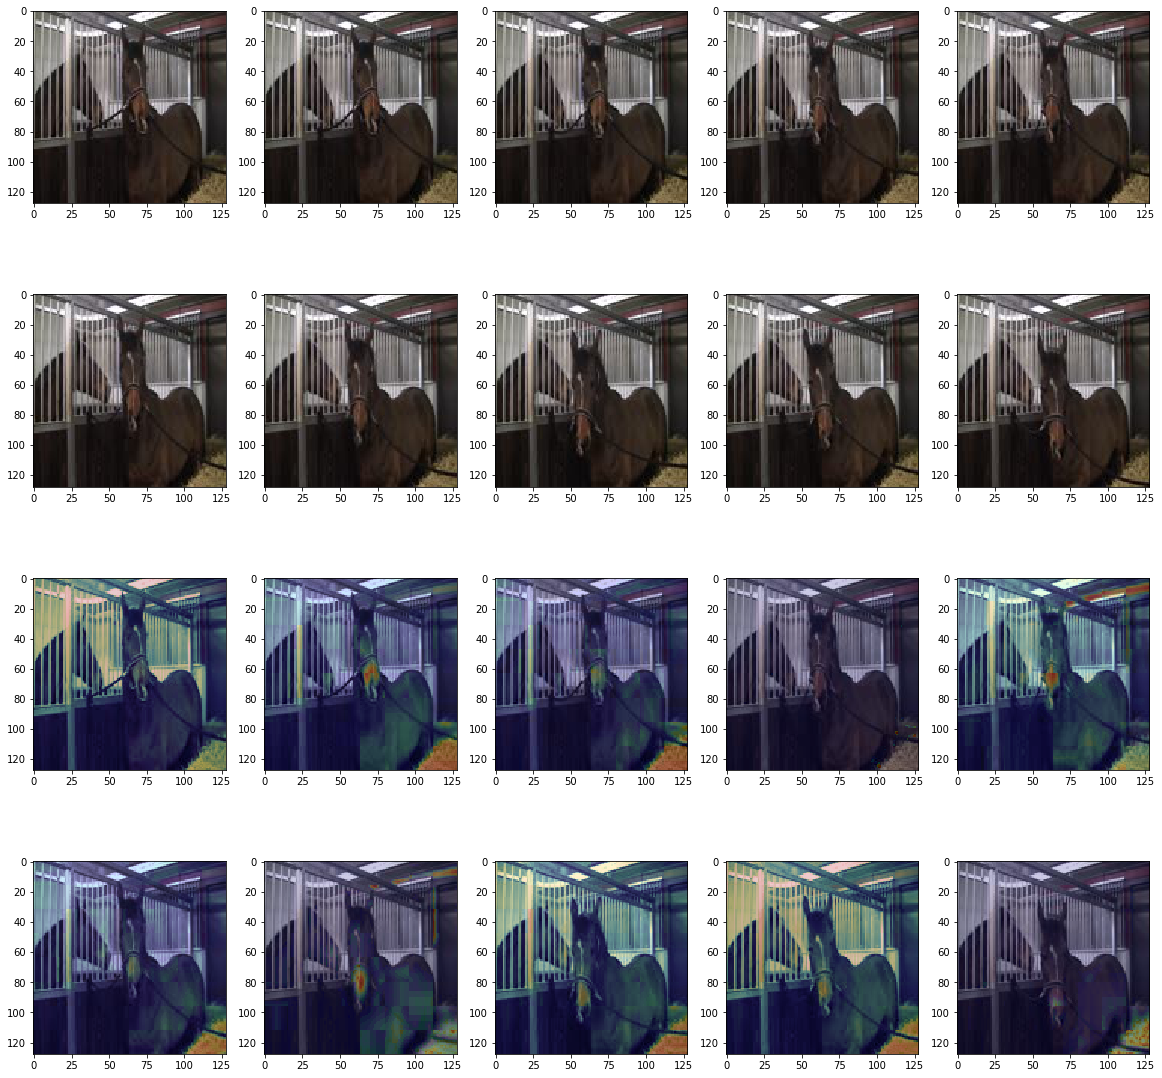

[ 0.97774637  0.01279034]
[ 0.99168915  0.00312271]
[ 0.99299002  0.00278417]
[ 0.99449807  0.00294291]
[ 0.99581796  0.00225513]
[ 0.99635738  0.00153835]
[ 0.99775189  0.00202645]
[ 0.99844921  0.00123806]
[ 0.99777967  0.00102238]
[ 0.99871111  0.00139166]
[[[1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]]]


In [38]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, subject=1)
# print(batch_img.shape)
# print(type(batch_img))
batch_img = np.array(batch_img, dtype=np.float32)
# print(type(batch_img))
# print(batch_img)

batch_label = np.array(batch_label, dtype=np.uint8)
# print(type(batch_label))
# print(batch_label)
run_on_one_sequence(sess, model, batch_img)

[[[ 0.85630447  0.14097758]
  [ 0.95900494  0.04600536]
  [ 0.95531017  0.03565766]
  [ 0.94939733  0.03614748]
  [ 0.94369143  0.03637324]
  [ 0.92151344  0.05535826]
  [ 0.92621452  0.06218914]
  [ 0.91986233  0.0786285 ]
  [ 0.91503698  0.06625751]
  [ 0.91726464  0.08279873]]]


/home/sofia/miniconda3/envs/pfr_june/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


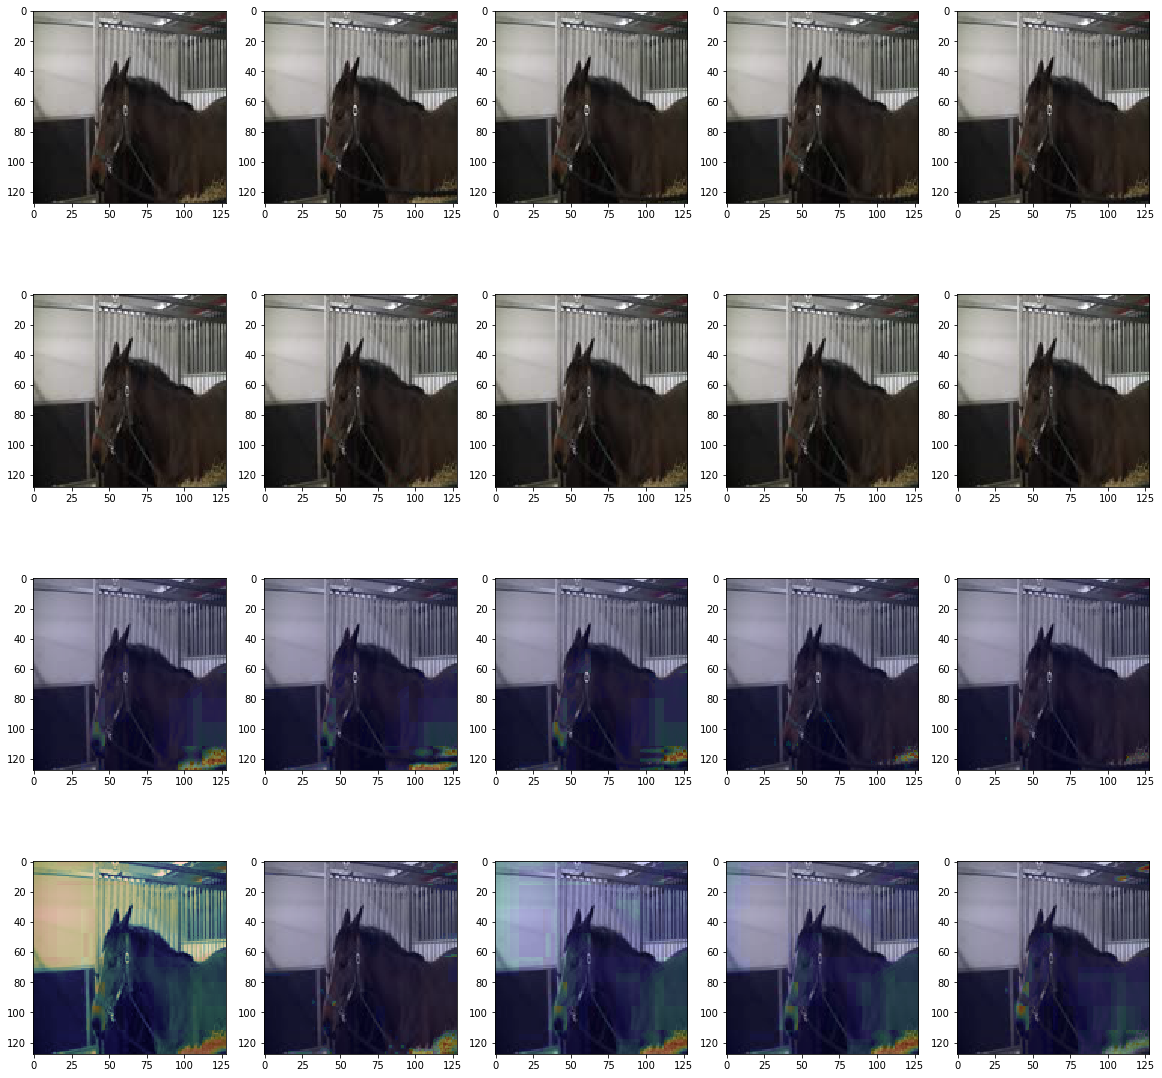

[ 0.85630447  0.14097758]
[ 0.95900494  0.04600536]
[ 0.95531017  0.03565766]
[ 0.94939733  0.03614748]
[ 0.94369143  0.03637324]
[ 0.92151344  0.05535826]
[ 0.92621452  0.06218914]
[ 0.91986233  0.0786285 ]
[ 0.91503698  0.06625751]
[ 0.91726464  0.08279873]
[[[1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]]]


In [39]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, subject=1)

batch_img = np.array(batch_img, dtype=np.float32)


batch_label = np.array(batch_label, dtype=np.uint8)

run_on_one_sequence(sess, model, batch_img)

[[[  9.97378349e-01   5.36801154e-03]
  [  9.99175727e-01   1.57475017e-03]
  [  9.99234438e-01   1.68232655e-03]
  [  9.99353945e-01   1.09618646e-03]
  [  9.99356687e-01   9.05828725e-04]
  [  9.99473035e-01   1.02766056e-03]
  [  9.99434412e-01   1.04614010e-03]
  [  9.99431908e-01   1.08082744e-03]
  [  9.99396205e-01   1.03229401e-03]
  [  9.99443114e-01   9.98838223e-04]]]


/home/sofia/miniconda3/envs/pfr_june/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/sofia/Documents/painface-recognition/notebooks/utils.py:364: RuntimeWarning: invalid value encountered in true_divide
  cam = resize(cam, (128,128), preserve_range=True)


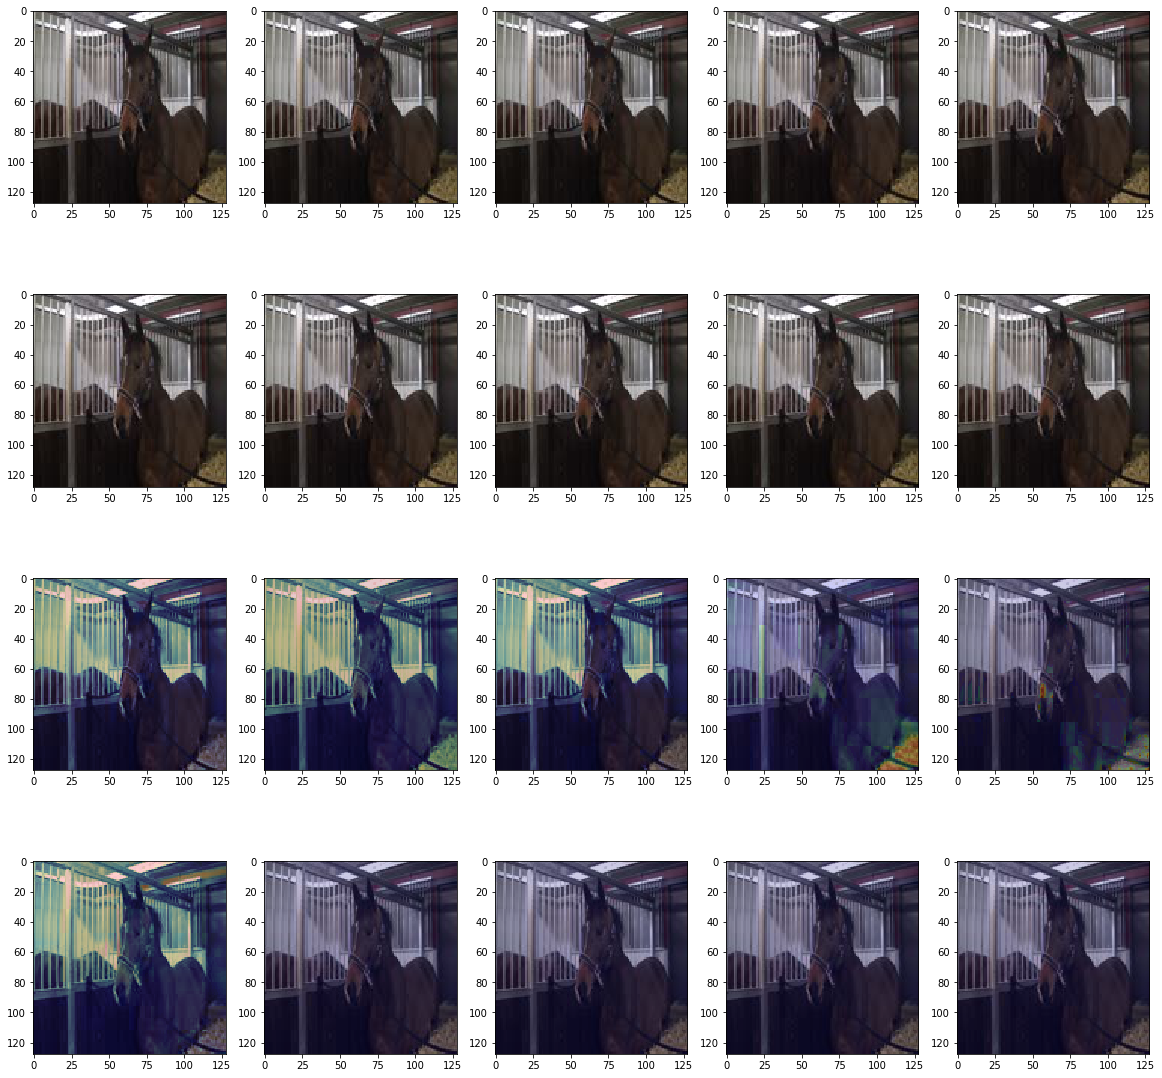

[ 0.99737835  0.00536801]
[ 0.99917573  0.00157475]
[ 0.99923444  0.00168233]
[ 0.99935395  0.00109619]
[  9.99356687e-01   9.05828725e-04]
[ 0.99947304  0.00102766]
[ 0.99943441  0.00104614]
[ 0.99943191  0.00108083]
[ 0.9993962   0.00103229]
[  9.99443114e-01   9.98838223e-04]
[[[1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]]]


In [40]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, subject=1)

batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)

run_on_one_sequence(sess, model, batch_img)

[[[ 0.36655092  0.70155591]
  [ 0.58464295  0.63709044]
  [ 0.69407308  0.4609428 ]
  [ 0.6352458   0.40817371]
  [ 0.69342458  0.30743319]
  [ 0.65984112  0.33280727]
  [ 0.79025805  0.3943468 ]
  [ 0.71901965  0.3617523 ]
  [ 0.68714541  0.41534004]
  [ 0.60974407  0.44038701]]]


/home/sofia/miniconda3/envs/pfr_june/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


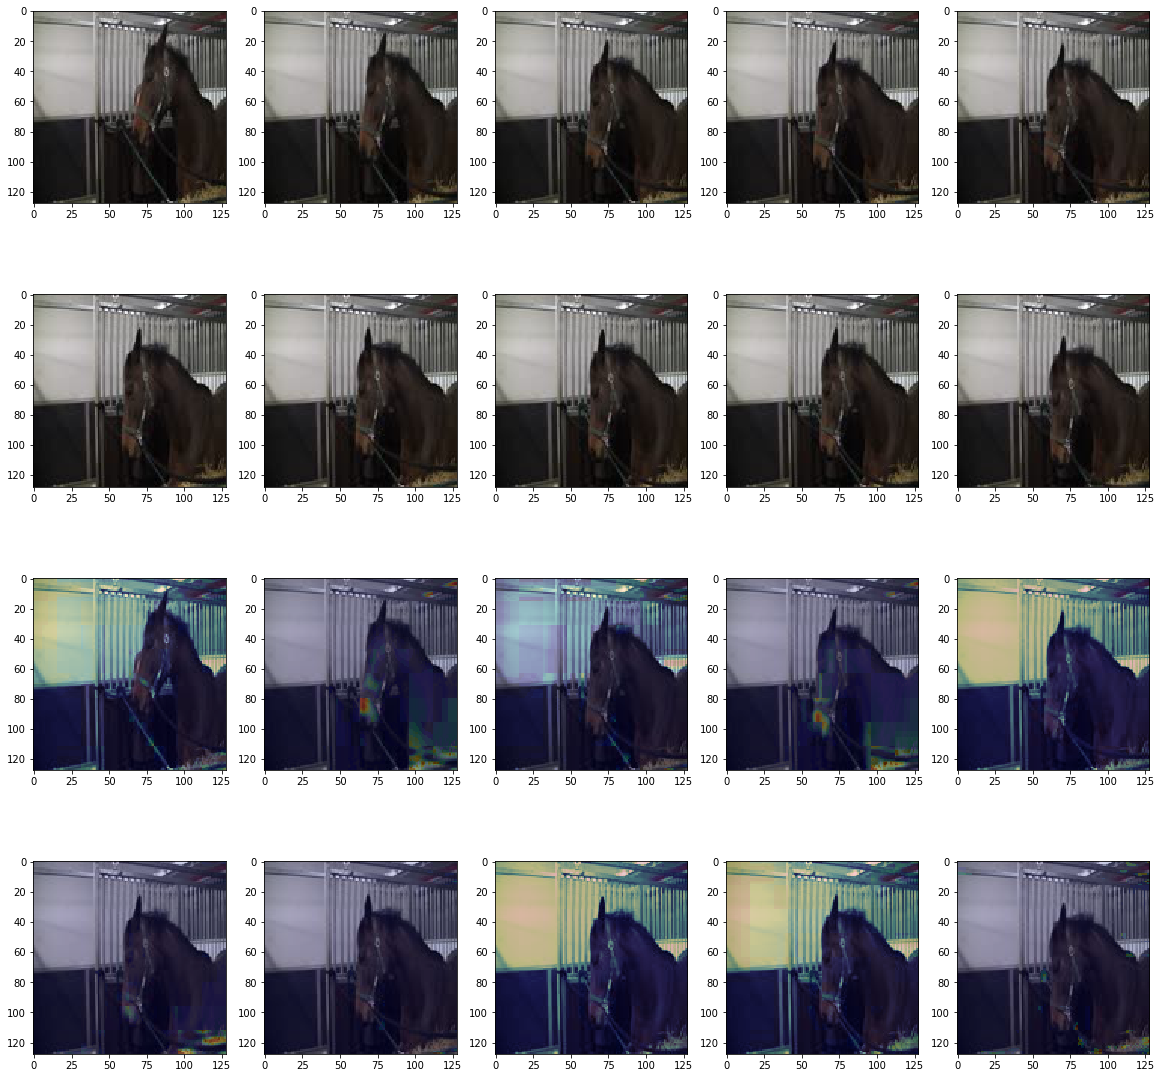

[ 0.36655092  0.70155591]
[ 0.58464295  0.63709044]
[ 0.69407308  0.4609428 ]
[ 0.6352458   0.40817371]
[ 0.69342458  0.30743319]
[ 0.65984112  0.33280727]
[ 0.79025805  0.3943468 ]
[ 0.71901965  0.3617523 ]
[ 0.68714541  0.41534004]
[ 0.60974407  0.44038701]
[[[1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]]]


In [41]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, subject=1)
batch_img = np.array(batch_img, dtype=np.float32)
batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img)

[[[ 0.90965712  0.04316767]
  [ 0.93401122  0.047555  ]
  [ 0.93457854  0.05622772]
  [ 0.94242525  0.06345291]
  [ 0.95158803  0.04859888]
  [ 0.9445281   0.05248059]
  [ 0.95913684  0.03735724]
  [ 0.96114576  0.03614176]
  [ 0.95874888  0.03859904]
  [ 0.9564507   0.03683301]]]


/home/sofia/miniconda3/envs/pfr_june/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/sofia/Documents/painface-recognition/notebooks/utils.py:364: RuntimeWarning: invalid value encountered in true_divide
  cam = resize(cam, (128,128), preserve_range=True)


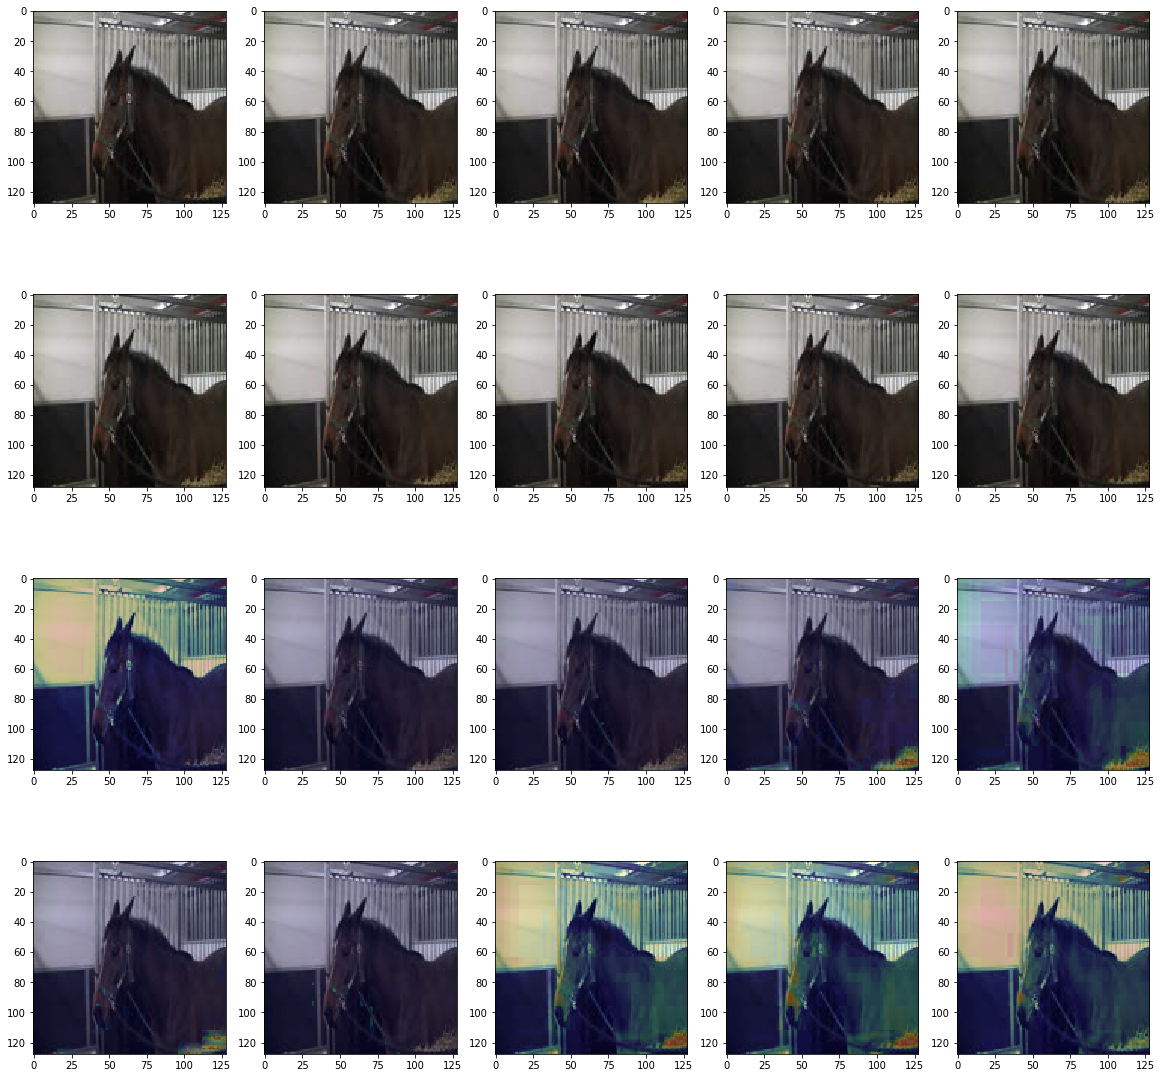

[ 0.90965712  0.04316767]
[ 0.93401122  0.047555  ]
[ 0.93457854  0.05622772]
[ 0.94242525  0.06345291]
[ 0.95158803  0.04859888]
[ 0.9445281   0.05248059]
[ 0.95913684  0.03735724]
[ 0.96114576  0.03614176]
[ 0.95874888  0.03859904]
[ 0.9564507   0.03683301]
[[[1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]
  [1 0]]]


In [42]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, subject=1)
batch_img = np.array(batch_img, dtype=np.float32)
batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img)

[[[  2.08451762e-03   9.96992111e-01]
  [  3.76115291e-04   9.99016047e-01]
  [  3.03942012e-04   9.99287188e-01]
  [  2.07814141e-04   9.99702513e-01]
  [  2.16620872e-04   9.99492288e-01]
  [  1.48206702e-04   9.99398708e-01]
  [  1.71775493e-04   9.99754012e-01]
  [  1.69759529e-04   9.99767125e-01]
  [  1.81963274e-04   9.99785841e-01]
  [  1.35725903e-04   9.99808967e-01]]]


/home/sofia/miniconda3/envs/pfr_june/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/sofia/Documents/painface-recognition/notebooks/utils.py:364: RuntimeWarning: invalid value encountered in true_divide
  cam = resize(cam, (128,128), preserve_range=True)


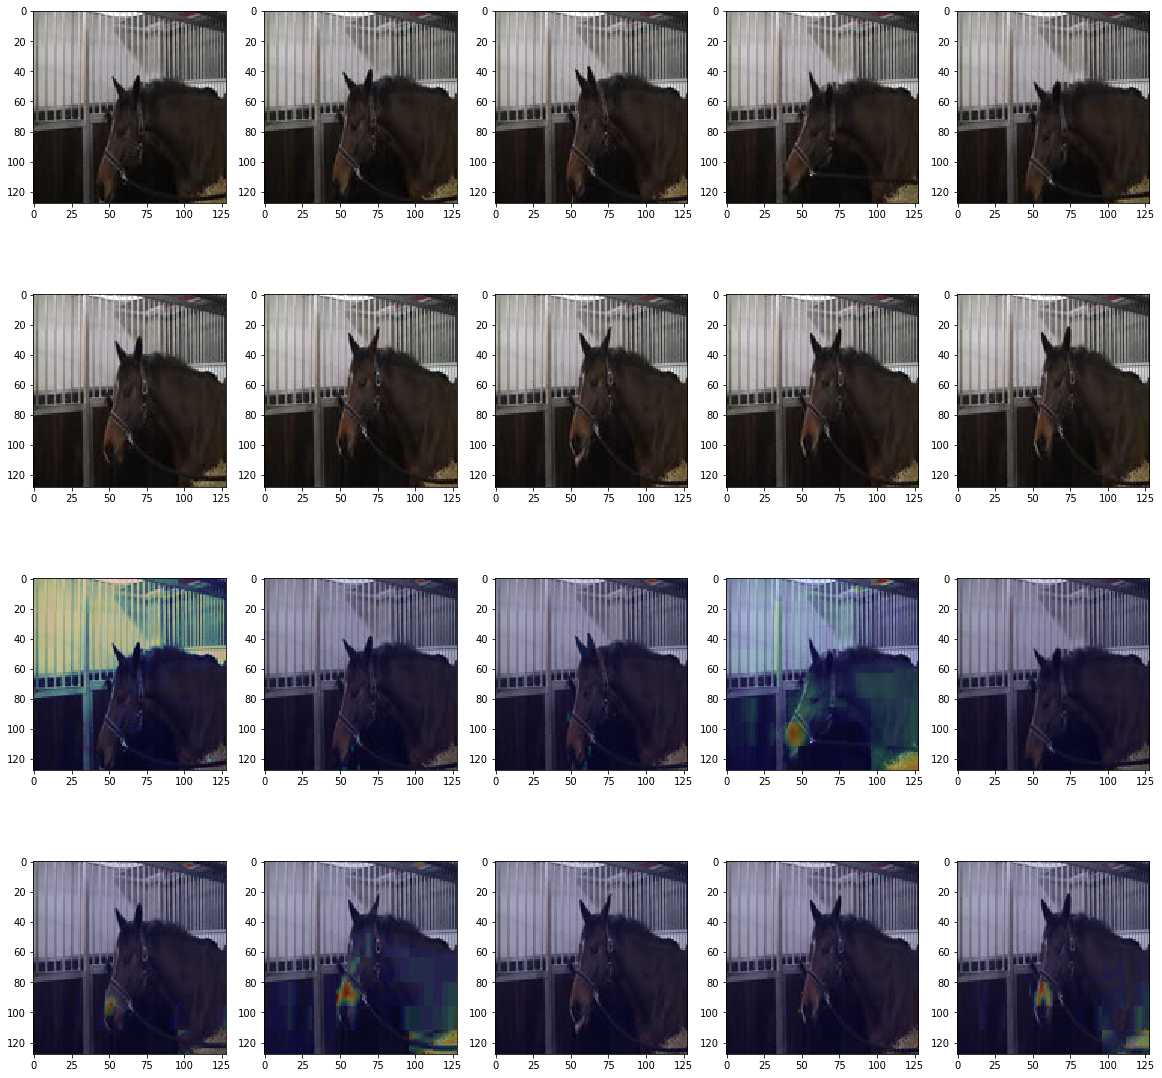

[ 0.00208452  0.99699211]
[  3.76115291e-04   9.99016047e-01]
[  3.03942012e-04   9.99287188e-01]
[  2.07814141e-04   9.99702513e-01]
[  2.16620872e-04   9.99492288e-01]
[  1.48206702e-04   9.99398708e-01]
[  1.71775493e-04   9.99754012e-01]
[  1.69759529e-04   9.99767125e-01]
[  1.81963274e-04   9.99785841e-01]
[  1.35725903e-04   9.99808967e-01]
[[[0 1]
  [0 1]
  [0 1]
  [0 1]
  [0 1]
  [0 1]
  [0 1]
  [0 1]
  [0 1]
  [0 1]]]


In [43]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, subject=1)
batch_img = np.array(batch_img, dtype=np.float32)
batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img)

In [11]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, subject=1)
print(batch_img[0,0].shape)
utils.make_video_from_frames(batch_img, 'subject1_rgb.avi')

(128, 128, 3)


In [32]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, subject=1)
print(batch_img[0,0].shape)
utils.make_video_from_frames(batch_img, 'subject1_rgb_2fps.mp4')

(128, 128, 3)
(1, 10, 128, 128, 3)


In [17]:
import io
import base64
from IPython.display import HTML

a = input()

video = io.open('subject1_rgb_2fps.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

<video controls src="subject1_rgb_2fps.mp4" />

In [10]:
%%HTML
<video width="128" height="128" controls>
  <source src="subject1_rgb_2fps.mp4 " type="video/avi">
</video>

In [19]:
from IPython.display import HTML

HTML("""
<video width="128" height="128" controls>
  <source src="subject1_rgb_2fps.mp4" type="video/mp4">
</video>
""")

<video controls src="subject1_rgb_2fps.mp4"/>

In [12]:
%%HTML
<div align="middle">
<video width="80%" controls>
      <source src="/home/usr/sofia/Documents/painface-recognition/notebooks/subject1_rgb_2fps.mp4" type="video/mp4">
</video></div>

#########################################
# explicitly calling the HTML renderer:
#########################################
from IPython.display import HTML

HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="/home/usr/sofia/Documents/painface-recognition/notebooks/subject1_rgb_2fps.mp4" type="video/mp4">
</video></div>""")

In [13]:
def video(fname, mimetype):
    from IPython.display import HTML
    video_encoded = open(fname, "rb").read() #.encode("base64")
    video_tag = '<video controls alt="test" src="data:video/{0};base64,{1}">'.format(mimetype, video_encoded)
    return HTML(data=video_tag)

In [14]:
video("subject1_rgb_2fps.mp4", "mp4")